<a href="https://colab.research.google.com/github/DataDrivenAkanksha/deep_learning_facemask_detection/blob/main/Face_Mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use the following Face Mask detection Dataset link and create an end-to-end project on Colab to predict whether person is wearing mask or not.

https://www.kaggle.com/datasets/omkargurav/face-mask-dataset/data


i. Import the dataset in Colab and perform the EDA and do the visualizations.

ii. Create model from scratch using your own number of filters, loss functions, no. of epochs and check the accuracy.

iii. Now use the pretrained model to check if accuracy gets improved.

iv. After that, go for data augmentation and further check if accuracy has improved.

v. Compare the training and testing accuracy with all these 3 approaches and suggest the best model.

In [39]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [40]:
!kaggle datasets download -d omkargurav/face-mask-dataset

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [41]:
import zipfile
zip_ref = zipfile.ZipFile('/content/face-mask-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Load and Explore Dataset¶
The dataset contains two folders:

with_mask/: Images of people wearing masks
without_mask/: Images of people not wearing masks
We will read images from both folders and assign labels accordingly (1 = with mask, 0 = without mask).

In [42]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [43]:
ds=keras.utils.image_dataset_from_directory(
    directory='/content/data',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(150,150)
)



Found 7553 files belonging to 2 classes.


In [44]:
# Normalize
def process(image,label):
    image=tf.cast(image/255,tf.float32)
    return image,label
dataset=ds.map(process)


In [45]:
# Get dataset size
dataset_size = dataset.cardinality().numpy()
train_size = int(0.8 * dataset_size)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)


In [46]:
import numpy as np

X = []
y = []

for image_batch, label_batch in dataset:
    X.append(image_batch.numpy())
    y.append(label_batch.numpy())

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (7553, 150, 150, 3)
y shape: (7553,)


Train Test split

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [48]:
print("Training data:", X_train.shape)
print("Testing data:", X_test.shape)

Training data: (6042, 150, 150, 3)
Testing data: (1511, 150, 150, 3)


In [53]:
# Create CNN Model
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(150,150,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [54]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,837,569 (18.45 MB)

 Trainable params: 4,837,121 (18.45 MB)

 Non-trainable params: 448 (1.75 KB)

In [55]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [56]:
history=model.fit(train_ds,epochs=20,validation_data=val_ds)

Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.8105 - loss: 1.3860 - val_accuracy: 0.5096 - val_loss: 5.5120
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - accuracy: 0.8759 - loss: 0.4090 - val_accuracy: 0.7781 - val_loss: 0.4825
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - accuracy: 0.9106 - loss: 0.2534 - val_accuracy: 0.9003 - val_loss: 0.2531
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9299 - loss: 0.1814 - val_accuracy: 0.8565 - val_loss: 0.3358
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9431 - loss: 0.1519 - val_accuracy: 0.9163 - val_loss: 0.2162
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9603 - loss: 0.1171 - val_accuracy: 0.9249 - val_loss: 0.1939
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9603 - loss: 0.1030 - val_accuracy: 0.9143 - val_loss: 0.2191
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.9747 - loss: 0.0702 - 

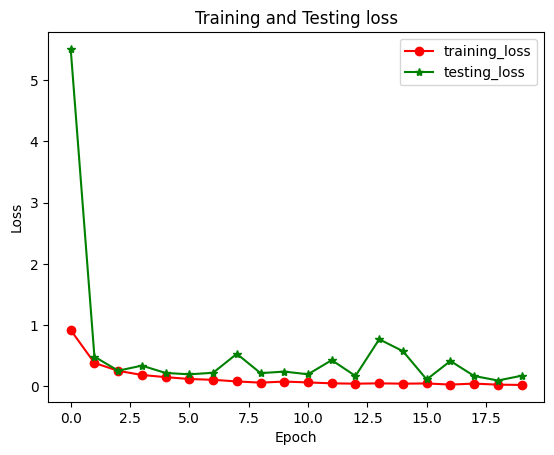

In [57]:
plt.plot(history.history['loss'],label='training_loss',marker='o',color='red')
plt.plot(history.history['val_loss'],label='testing_loss',marker='*',color='green')
plt.title('Training and Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

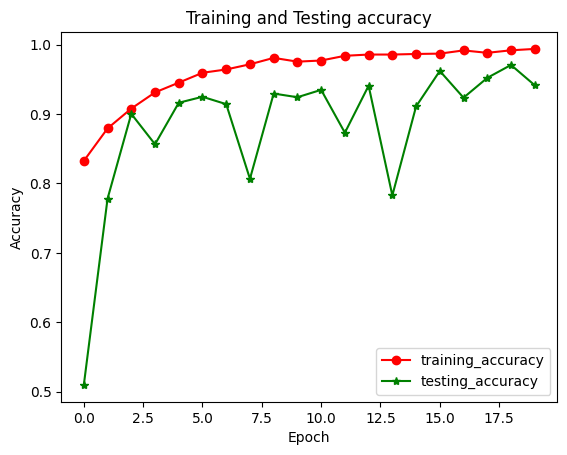

In [58]:
plt.plot(history.history['accuracy'],label='training_accuracy',marker='o',color='red')
plt.plot(history.history['val_accuracy'],label='testing_accuracy',marker='*',color='green')
plt.title('Training and Testing accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [59]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification_model(name, model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # If predictions are probabilities, convert to class labels
    if y_pred_train.ndim > 1 and y_pred_train.shape[1] == 1:
        # Binary classification with sigmoid
        y_pred_train = (y_pred_train > 0.5).astype(int).flatten()
        y_pred_test = (y_pred_test > 0.5).astype(int).flatten()

    return {
        'Model': name,
        'Accuracy Train (%)': accuracy_score(y_train, y_pred_train) * 100,
        'Accuracy Test (%)': accuracy_score(y_test, y_pred_test) * 100,
        'Precision': precision_score(y_test, y_pred_test, average='weighted'),
        'Recall': recall_score(y_test, y_pred_test, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred_test, average='weighted')
    }


models = [
    ('Basic_CNN', model),
    # Add more models if needed
]

results = [evaluate_classification_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]
results_df = pd.DataFrame(results).round(3)
print(results_df.to_string(index=False))

189/189 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
    Model  Accuracy Train (%)  Accuracy Test (%)  Precision  Recall  F1-Score
Basic_CNN              96.855             97.287      0.973   0.973     0.973


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


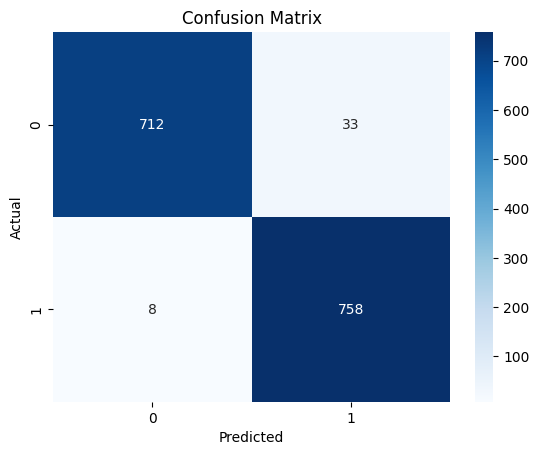

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Predict class probabilities
y_pred_test = model.predict(X_test)

# Convert probabilities to class labels
y_pred_test = (y_pred_test > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97       745
           1       0.96      0.99      0.97       766

    accuracy                           0.97      1511
   macro avg       0.97      0.97      0.97      1511
weighted avg       0.97      0.97      0.97      1511



In [62]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_test))


Counter({np.int32(1): 3062, np.int32(0): 2980})
Counter({np.int32(1): 766, np.int32(0): 745})


Pretrained Model VGG4 using here. only training the upper layers.

In [63]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

In [64]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150,150,3)
)

In [65]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
model_pretrain = Sequential()

model_pretrain.add(conv_base)
model_pretrain.add(Flatten())
model_pretrain.add(Dense(128,activation='relu'))
model_pretrain.add(Dropout(0.1))
model_pretrain.add(Dense(64,activation='relu'))
model_pretrain.add(Dropout(0.1))
model_pretrain.add(Dense(1,activation='sigmoid'))

In [67]:
conv_base.trainable = False

In [68]:
model_pretrain.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,771,713 (60.16 MB)

 Trainable params: 1,057,025 (4.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [69]:
model_pretrain.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [71]:
history1=model_pretrain.fit(train_ds,epochs=10,validation_data=val_ds)

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 151ms/step - accuracy: 0.9981 - loss: 0.0047 - val_accuracy: 0.9734 - val_loss: 0.1336
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 51s 207ms/step - accuracy: 0.9972 - loss: 0.0091 - val_accuracy: 0.9728 - val_loss: 0.1544
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 152ms/step - accuracy: 0.9963 - loss: 0.0144 - val_accuracy: 0.9787 - val_loss: 0.1045
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - accuracy: 0.9986 - loss: 0.0039 - val_accuracy: 0.9714 - val_loss: 0.1500
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 154ms/step - accuracy: 0.9980 - loss: 0.0071 - val_accuracy: 0.9781 - val_loss: 0.1057
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 28s 151ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 0.9794 - val_loss: 0.1286
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 40s 148ms/step - accuracy: 0.9990 - loss: 0.0034 - val_accuracy: 0.9721 - val_loss: 0.1283
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - accuracy: 0.9972 - loss: 0

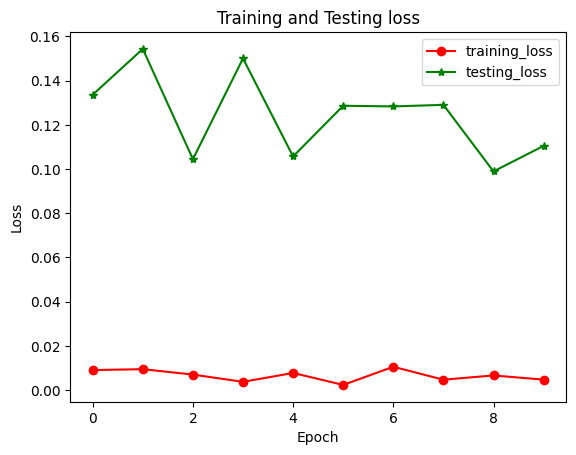

In [72]:
plt.plot(history1.history['loss'],label='training_loss',marker='o',color='red')
plt.plot(history1.history['val_loss'],label='testing_loss',marker='*',color='green')
plt.title('Training and Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

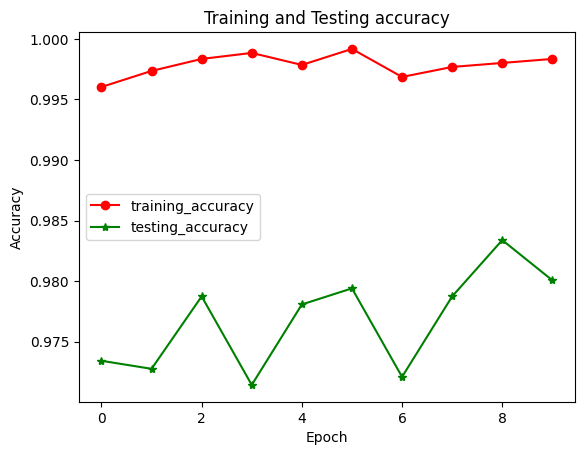

In [73]:
plt.plot(history1.history['accuracy'],label='training_accuracy',marker='o',color='red')
plt.plot(history1.history['val_accuracy'],label='testing_accuracy',marker='*',color='green')
plt.title('Training and Testing accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step


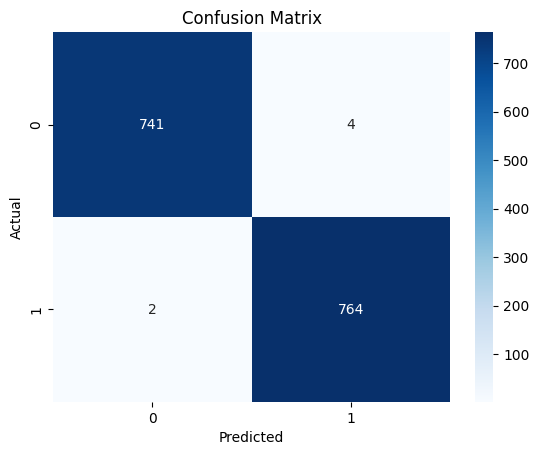

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Predict class probabilities
y_pred_test = model_pretrain.predict(X_test)

# Convert probabilities to class labels
y_pred_test = (y_pred_test > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [74]:

models = [
    ('Basic_CNN', model),
    ('Pretrained_vgg16', model_pretrain),
]

results = [evaluate_classification_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]
results_df = pd.DataFrame(results).round(3)
print(results_df.to_string(index=False))

189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step
           Model  Accuracy Train (%)  Accuracy Test (%)  Precision  Recall  F1-Score
       Basic_CNN              96.855             97.287      0.973   0.973     0.973
Pretrained_vgg16              99.603             99.603      0.996   0.996     0.996


After that, go for data augmentation and further check if accuracy has improved.

In [76]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [89]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the augmenter
train_datagen = ImageDataGenerator(

    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,

)

# No augmentation for validation/test
test_datagen = ImageDataGenerator()

# Create generators from NumPy arrays
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32,
    shuffle=True
)

validation_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=32,
    shuffle=False
)


In [90]:
model_pretrain_data_aug = Sequential()
model_pretrain_data_aug.add(conv_base)
model_pretrain_data_aug.add(Flatten())
model_pretrain_data_aug.add(Dense(128,activation='relu'))
model_pretrain_data_aug.add(Dropout(0.1))
model_pretrain_data_aug.add(Dense(64,activation='relu'))
model_pretrain_data_aug.add(Dropout(0.1))
model_pretrain_data_aug.add(Dense(1,activation='sigmoid'))

In [91]:
conv_base.trainable = False
model_pretrain_data_aug.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,771,713 (60.16 MB)

 Trainable params: 1,057,025 (4.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [92]:
model_pretrain_data_aug.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [93]:
history2 = model_pretrain_data_aug.fit(train_generator, epochs=10, validation_data=validation_generator)


Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 50s 243ms/step - accuracy: 0.8471 - loss: 0.3351 - val_accuracy: 0.9709 - val_loss: 0.0825
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 53s 281ms/step - accuracy: 0.9614 - loss: 0.0933 - val_accuracy: 0.9749 - val_loss: 0.0702
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 48s 251ms/step - accuracy: 0.9683 - loss: 0.0799 - val_accuracy: 0.9729 - val_loss: 0.0906
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 49s 260ms/step - accuracy: 0.9757 - loss: 0.0578 - val_accuracy: 0.9762 - val_loss: 0.0788
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 224ms/step - accuracy: 0.9823 - loss: 0.0521 - val_accuracy: 0.9749 - val_loss: 0.0782
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 83s 227ms/step - accuracy: 0.9790 - loss: 0.0543 - val_accuracy: 0.9768 - val_loss: 0.0762
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 42s 220ms/step - accuracy: 0.9817 - loss: 0.0453 - val_accuracy: 0.9742 - val_loss: 0.0784
Epoch 8/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 41s 218ms/step - accuracy: 0.9857 - loss: 0

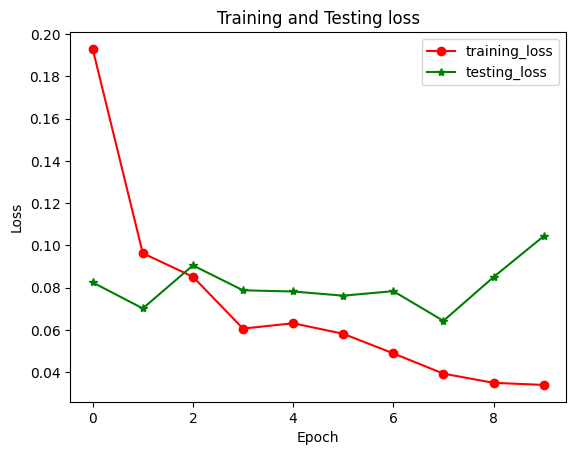

In [94]:
plt.plot(history2.history['loss'],label='training_loss',marker='o',color='red')
plt.plot(history2.history['val_loss'],label='testing_loss',marker='*',color='green')
plt.title('Training and Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

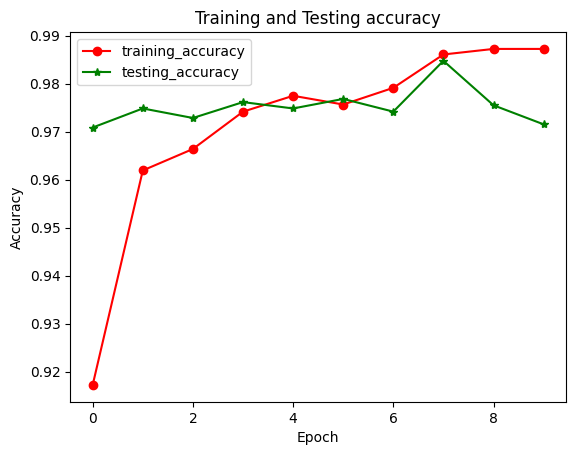

In [95]:
plt.plot(history2.history['accuracy'],label='training_accuracy',marker='o',color='red')
plt.plot(history2.history['val_accuracy'],label='testing_accuracy',marker='*',color='green')
plt.title('Training and Testing accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step


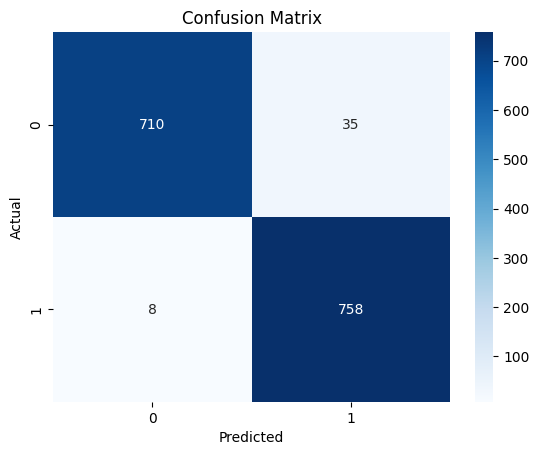

In [96]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Predict class probabilities
y_pred_test = model_pretrain_data_aug.predict(X_test)

# Convert probabilities to class labels
y_pred_test = (y_pred_test > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [97]:
models = [
    ('Basic_CNN', model),
    ('Pretrained_vgg16', model_pretrain),
    ('Pretrained_vgg16_data_aug', model_pretrain_data_aug),
]

results = [evaluate_classification_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]
results_df = pd.DataFrame(results).round(3)
print(results_df.to_string(index=False))

189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step
                    Model  Accuracy Train (%)  Accuracy Test (%)  Precision  Recall  F1-Score
                Basic_CNN              96.855             97.287      0.973   0.973     0.973
         Pretrained_vgg16              95.680             96.492      0.966   0.965     0.965
Pretrained_vgg16_data_aug              99.007             97.154      0.972   0.972     0.972
